In [1]:
########################################################
#
#	HAMSR Data receipe
#		Generate Data receipe  for 
#		HAMSR
#
#	Author: Amanda Weigel, Sriraksha Nagaraj
#	Date:	Feb 22, 2017
#	Information and Technology Systems Center (ITSC)
#       University of Alabama in Huntsville
#
#
########################################################

In [2]:
import pydap
from pydap.client import open_url


# Open data stream using OPeNDAP link to file and look for data fields

In [3]:
datafile = open_url('https://ghrc.nsstc.nasa.gov/opendap/fieldCampaigns/hs3/HAMSR/data/2013/HAMSR_L2_20130915T061329_20130916T050512_v01.nc')
print datafile.keys()

['time', 'lat', 'lon', 'altitude', 'TB', 'inc', 'AClat', 'AClon', 'ACroll', 'ACpitch', 'ACheading', 'PWV', 'CLW', 'sea_ice_flag', 'anc_sfc_ht', 'anc_Psfc', 'land_flag', 'anc_ws', 'ham_airT', 'ham_airQ', 'ham_airL', 'ham_airRH', 'ham_airPT', 'ham_airEPT', 'ham_LCL', 'ham_LFC', 'ham_prof_PWV', 'ham_prof_CLW', 'ham_sfc_airT', 'ham_sfc_airQ', 'ham_sfc_airRH', 'ham_FltLvl_airT', 'ham_FltLvl_airQ', 'ham_FltLvl_airRH', 'ham_ret_qual_flag', 'ham_pres_levels', 'ham_airHt', 'ham_dBz', 'ham_dBz_heights']


# Let's plot the ham_dBz field

In [4]:
#Import needed Python packages
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
from scipy import ndimage
from datetime import datetime

# Define the start and end date/time along the flight track

In [5]:
#Enter date and time in MMDDYYYYThh:mm:ssUTC
start_string = "9/15/2013T20:00:00UTC"
end_string = "9/15/2013T21:00:00UTC"

datetime_format = "%Y-%m-%d %H:%M:%S"
unit_string = datafile['time'].units.replace("seconds since ", "").replace(".0", "")
reference_time = datetime.strptime(unit_string, datetime_format)

#Converts defined start/end time to data file time units
Format = "%m/%d/%YT%H:%M:%S%Z"
datatime_start = datetime.strptime(start_string, Format)
datatime_end = datetime.strptime(end_string, Format)
start_diff = datatime_start - reference_time
end_diff = datatime_end - reference_time
start_value = float(start_diff.total_seconds())
end_value = float(end_diff.total_seconds())
subset_array = np.where((datafile['time'][:] >= start_value) & (datafile['time'][:] <= end_value))

start_at = np.min(subset_array)
end_at = np.max(subset_array)

#print "start at:" + str(start_at)
#print "end at:" + str(end_at)


# Define the variables for cross-track length and the lat/lon subset of the data for the desired variable

In [6]:
#Set 'length of cross track' as dim_cross_track_length
dim_cross_track_length = 42
width = 1

#Get 'hamsr_dbZ' variable as var_ham_dBz
var_ham_dBz = datafile['ham_dBz'][0,start_at:end_at,:]

#Get 'latitude' variable as var_lat
var_lat = datafile['lat'][start_at:end_at,:]

#Get 'longitude' variable as var_lon
var_lon = datafile['lon'][start_at:end_at,:]

#Get latitudes and longitudes for range
lats = np.sort(np.unique(np.round(var_lat,3)))
lons = np.sort(np.unique(np.round(var_lon,3)))

#Define plotting variable
img = np.zeros((lons.size,lats.size))

#Compute pixel values for plot
for at in range(0, end_at - start_at):
	for ct in range(0, dim_cross_track_length):
		index_lat = lats.size - np.searchsorted(lats, var_lat[at,ct])
		index_lon = np.searchsorted(lons, var_lon[at,ct])
		
		if(index_lat >=0 and index_lat < lats.size and index_lon >=0 and index_lon < lons.size):
			img[index_lon,index_lat] = var_ham_dBz[0,at,ct]; #If error occurs try var_ham_dBz[at,ct]

#Define maximum latitude and longitude bounds		
max_lat = np.max(lats)*0.001
min_lat = np.min(lats)*0.001
max_lon = np.max(lons)*0.001
min_lon = np.min(lons)*0.001


# Create plot of HAMSR data

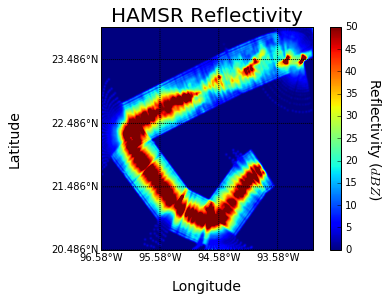

In [7]:
#Plot geographic boundaries, parallels, and meridians
m = Basemap(projection='merc', llcrnrlon=(min_lon) , llcrnrlat=(min_lat) , urcrnrlon=(max_lon), urcrnrlat=(max_lat ), resolution='c')
m.drawcoastlines()
m.drawstates()
m.fillcontinents(color='coral',lake_color='aqua')
parallels = np.arange(min_lat,max_lat ,1)
m.drawparallels(parallels,labels=[1,0,0,1])
meridians = np.arange(min_lon , max_lon ,1)
m.drawmeridians(meridians,labels=[1,0,0,1])

#Set plot dimensions
x0,y0 = m(min_lon, min_lat)
x1,y1 = m(max_lon, max_lat)
img = ndimage.filters.gaussian_filter(img,12)

#Create and format plot
plt.title('HAMSR Reflectivity', fontsize=20)

plt.imshow(img, extent=(x0,x1,y0,y1), vmax=50, vmin=0); #change vmax to alter HAMSR reflectivity(dBZ) color mapping

#Format plot color bar and axis labels
cbar = plt.colorbar()
cbar.set_label('Reflectivity ($dBZ$)', rotation=270, labelpad =25, fontsize =14)

plt.xlabel("Longitude", labelpad =30, fontsize =14)
plt.ylabel("Latitude", labelpad =80, fontsize =14)
plt.show();
